In [1]:
import imblearn
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox

In [2]:
df = pd.read_csv("contributors2.csv")
selected_columns = ['name_with_owner','is_core', 'repos', 'gists', 'followers', 'following', 'months_experience', 'has_bio']

# Subset the DataFrame based on the selected columns
c1 = df[selected_columns].copy()
#get projects not in cluster
c2_cols = ['microsoft/azuredatastudio', 'xamarin/xamarin-macios', 'pingcap/docs']
c3_cols = ['umijs/umi', 'netbox-community/netbox', 'grafana/loki', 'awsdocs/aws-doc-sdk-examples', 'vueuse/vueuse',
     'yuzu-emu/yuzu', 'TanStack/query', 'lvgl/lvgl', 'arendst/Tasmota', 'Aircoookie/WLED']
#combine into one list
c1_cols = c2_cols + c3_cols
c1 = c1[~c1['name_with_owner'].isin(c1_cols)]
c1 = c1.drop(columns = 'name_with_owner')

In [3]:
c1

,is_core,repos,gists,followers,following,months_experience,has_bio
0,0,90,5,450,67,115.45,1
1,0,88,14,2685,7,151.54,1
2,0,102,72,42,0,166.86,0
3,0,37,15,11,10,152.46,1
4,0,50,1,58,17,137.50,1
...,...,...,...,...,...,...,...
8439,0,19,0,5,1,126.98,0
8440,0,0,0,0,0,28.65,0
8441,0,1,1,13,3,124.58,1
8442,0,0,0,0,0,9.54,0


In [4]:
X = c1.drop(columns = 'is_core')
y = c1['is_core']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [5]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [6]:
train_df

,repos,gists,followers,following,months_experience,has_bio,is_core
4365,43,0,13,18,66.28,0,0
3832,15,0,5,3,76.61,1,0
7347,0,0,0,0,45.56,0,0
7928,81,0,10,20,111.90,1,0
4780,0,0,0,0,42.18,0,0
...,...,...,...,...,...,...,...
4897,105,4,34,9,99.40,0,0
7503,75,8,15,24,97.32,0,0
5522,12,2,140,36,147.34,1,0
6784,44,0,91,10,120.69,0,0


In [7]:
print(train_df['is_core'].value_counts())
print(test_df['is_core'].value_counts())

0    3182
1     181
Name: is_core, dtype: int64
0    788
1     53
Name: is_core, dtype: int64


In [8]:
adasyn = imblearn.over_sampling.ADASYN(random_state = 0)
x_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)
c1_train = pd.DataFrame(data=x_resampled_adasyn, columns=['repos', 'gists', 'followers', 'following', 'months_experience', 'has_bio'])  # Replace column names as needed
c1_train['is_core'] = y_resampled_adasyn  # Assuming 'target' is the name of your target column
c1_train['has_bio'] = c1_train['has_bio'].apply(lambda x: 1 if x >= 0.5 else 0)
c1_train

,repos,gists,followers,following,months_experience,has_bio,is_core
0,43,0,13,18,66.280000,0,0
1,15,0,5,3,76.610000,1,0
2,0,0,0,0,45.560000,0,0
3,81,0,10,20,111.900000,1,0
4,0,0,0,0,42.180000,0,0
...,...,...,...,...,...,...,...
6359,4,1,3,3,144.199686,0,1
6360,12,0,48,15,84.297888,1,1
6361,8,0,11,4,56.887307,0,1
6362,11,0,45,10,76.911282,1,1


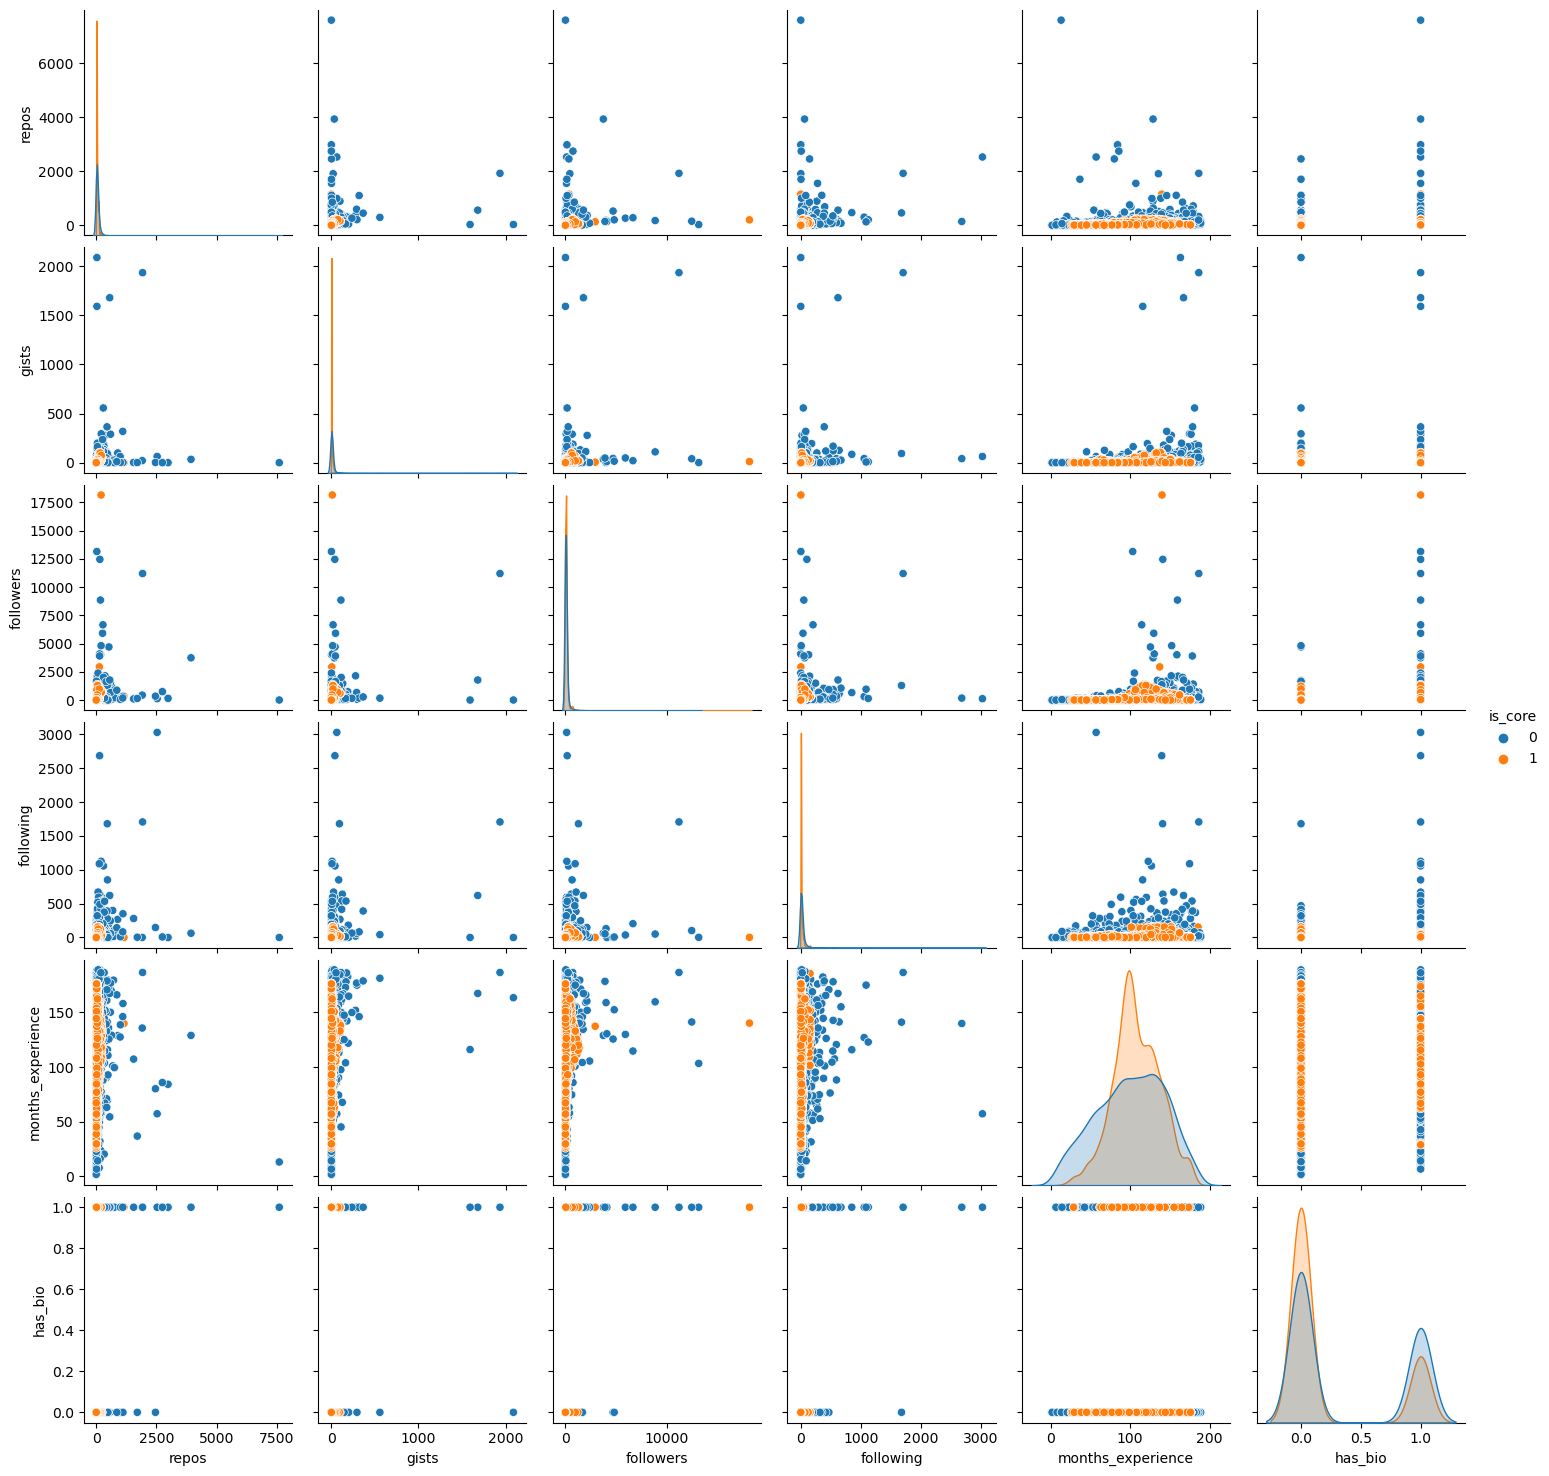

In [9]:
sns.pairplot(c1_train, hue = 'is_core')

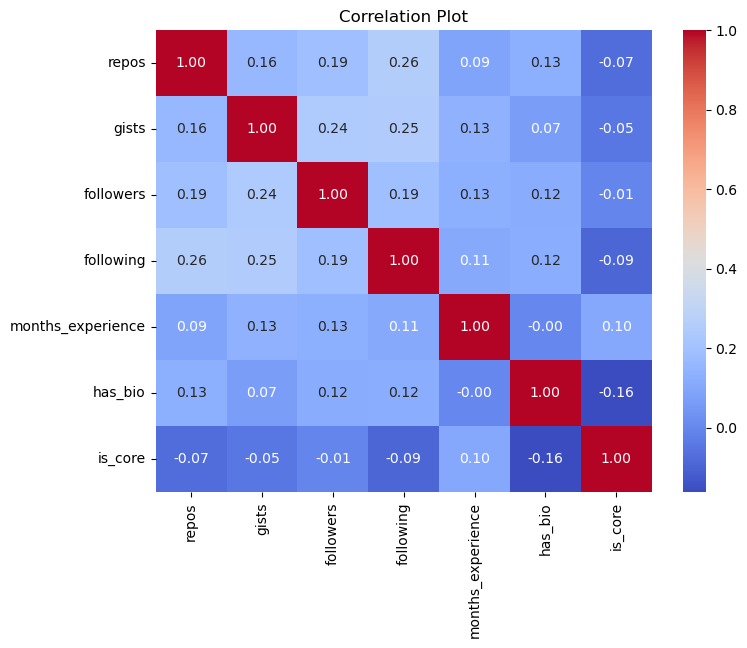

In [10]:
# Creating a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(c1_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adding a title
plt.title('Correlation Plot')

# Displaying the plot
plt.show() 

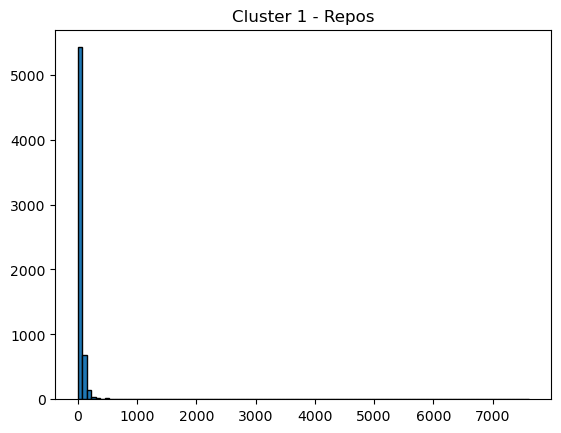

In [11]:
plt.hist(c1_train.repos, bins=100, edgecolor='black')
plt.title('Cluster 1 - Repos')
plt.show()

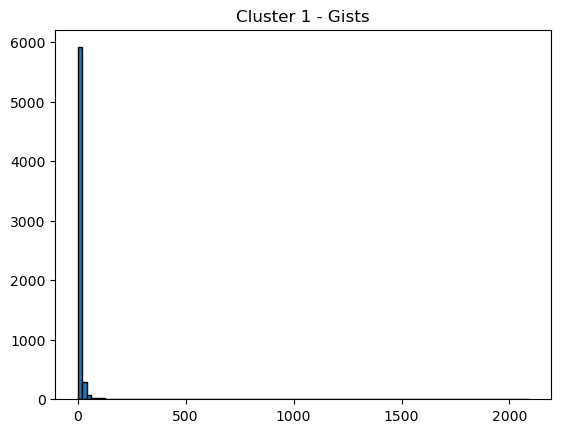

In [12]:
plt.hist(c1_train.gists, bins=100, edgecolor='black')
plt.title('Cluster 1 - Gists')
plt.show()

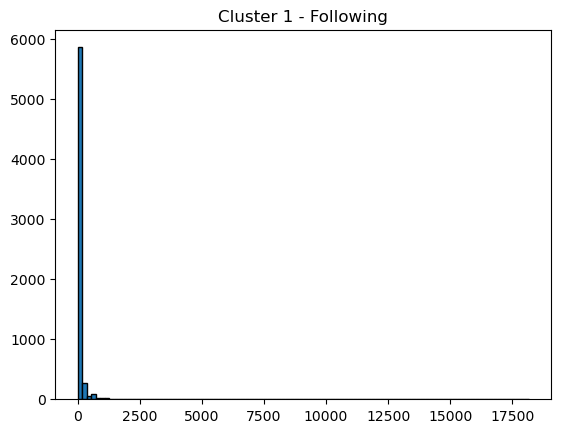

In [13]:
plt.hist(c1_train.followers, bins=100, edgecolor='black')
plt.title('Cluster 1 - Following')
plt.show()

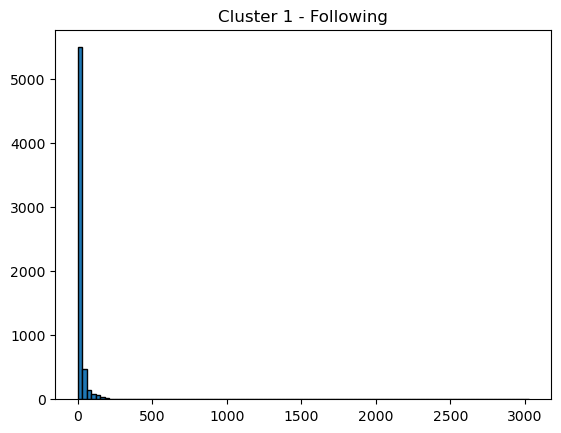

In [14]:
plt.hist(c1_train.following, bins=100, edgecolor='black')
plt.title('Cluster 1 - Following')
plt.show()

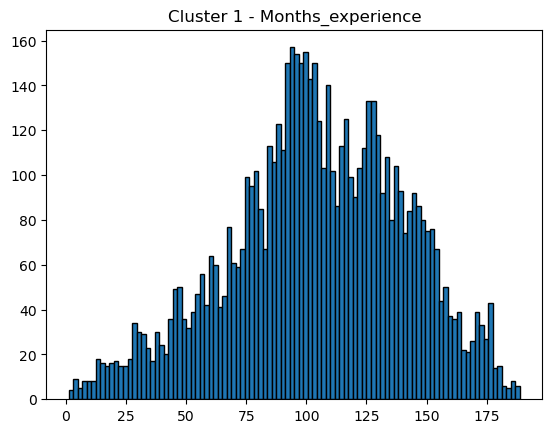

In [15]:
plt.hist(c1_train.months_experience, bins=100, edgecolor='black')
plt.title('Cluster 1 - Months_experience')
plt.show()

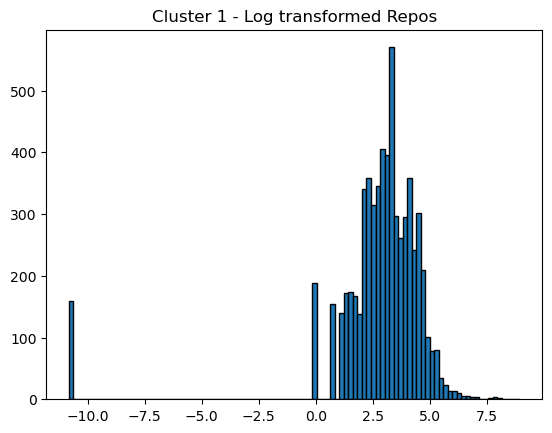

In [16]:
plt.hist(np.log(c1_train.repos+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 1 - Log transformed Repos')
plt.show()

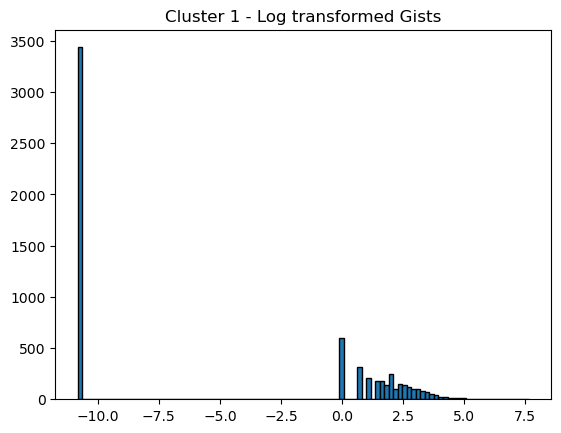

In [17]:
plt.hist(np.log(c1_train.gists+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 1 - Log transformed Gists')
plt.show()

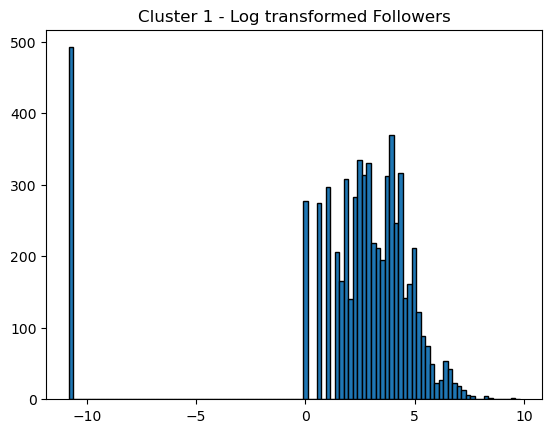

In [18]:
plt.hist(np.log(c1_train.followers+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 1 - Log transformed Followers')
plt.show()

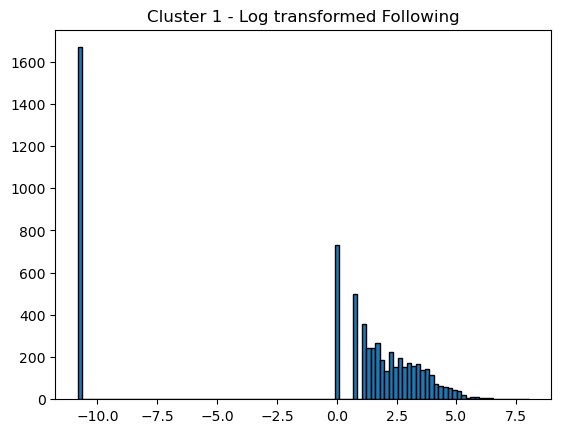

In [19]:
plt.hist(np.log(c1_train.following+2e-5), bins=100, edgecolor='black')
plt.title('Cluster 1 - Log transformed Following')
plt.show()

In [20]:
c1_train_log = c1_train.copy()
c1_train_log['repos'] = np.log(c1_train_log.repos+2e-5)
c1_train_log['gists'] = np.log(c1_train_log.gists+2e-5)
c1_train_log['followers'] = np.log(c1_train_log.followers+2e-5)
c1_train_log['following'] = np.log(c1_train_log.following+2e-5)
c1_train_log

,repos,gists,followers,following,months_experience,has_bio,is_core
0,3.761201,-10.819778,2.564951,2.890373,66.280000,0,0
1,2.708052,-10.819778,1.609442,1.098619,76.610000,1,0
2,-10.819778,-10.819778,-10.819778,-10.819778,45.560000,0,0
3,4.394449,-10.819778,2.302587,2.995733,111.900000,1,0
4,-10.819778,-10.819778,-10.819778,-10.819778,42.180000,0,0
...,...,...,...,...,...,...,...
6359,1.386299,0.000020,1.098619,1.098619,144.199686,0,1
6360,2.484908,-10.819778,3.871201,2.708052,84.297888,1,1
6361,2.079444,-10.819778,2.397897,1.386299,56.887307,0,1
6362,2.397897,-10.819778,3.806663,2.302587,76.911282,1,1


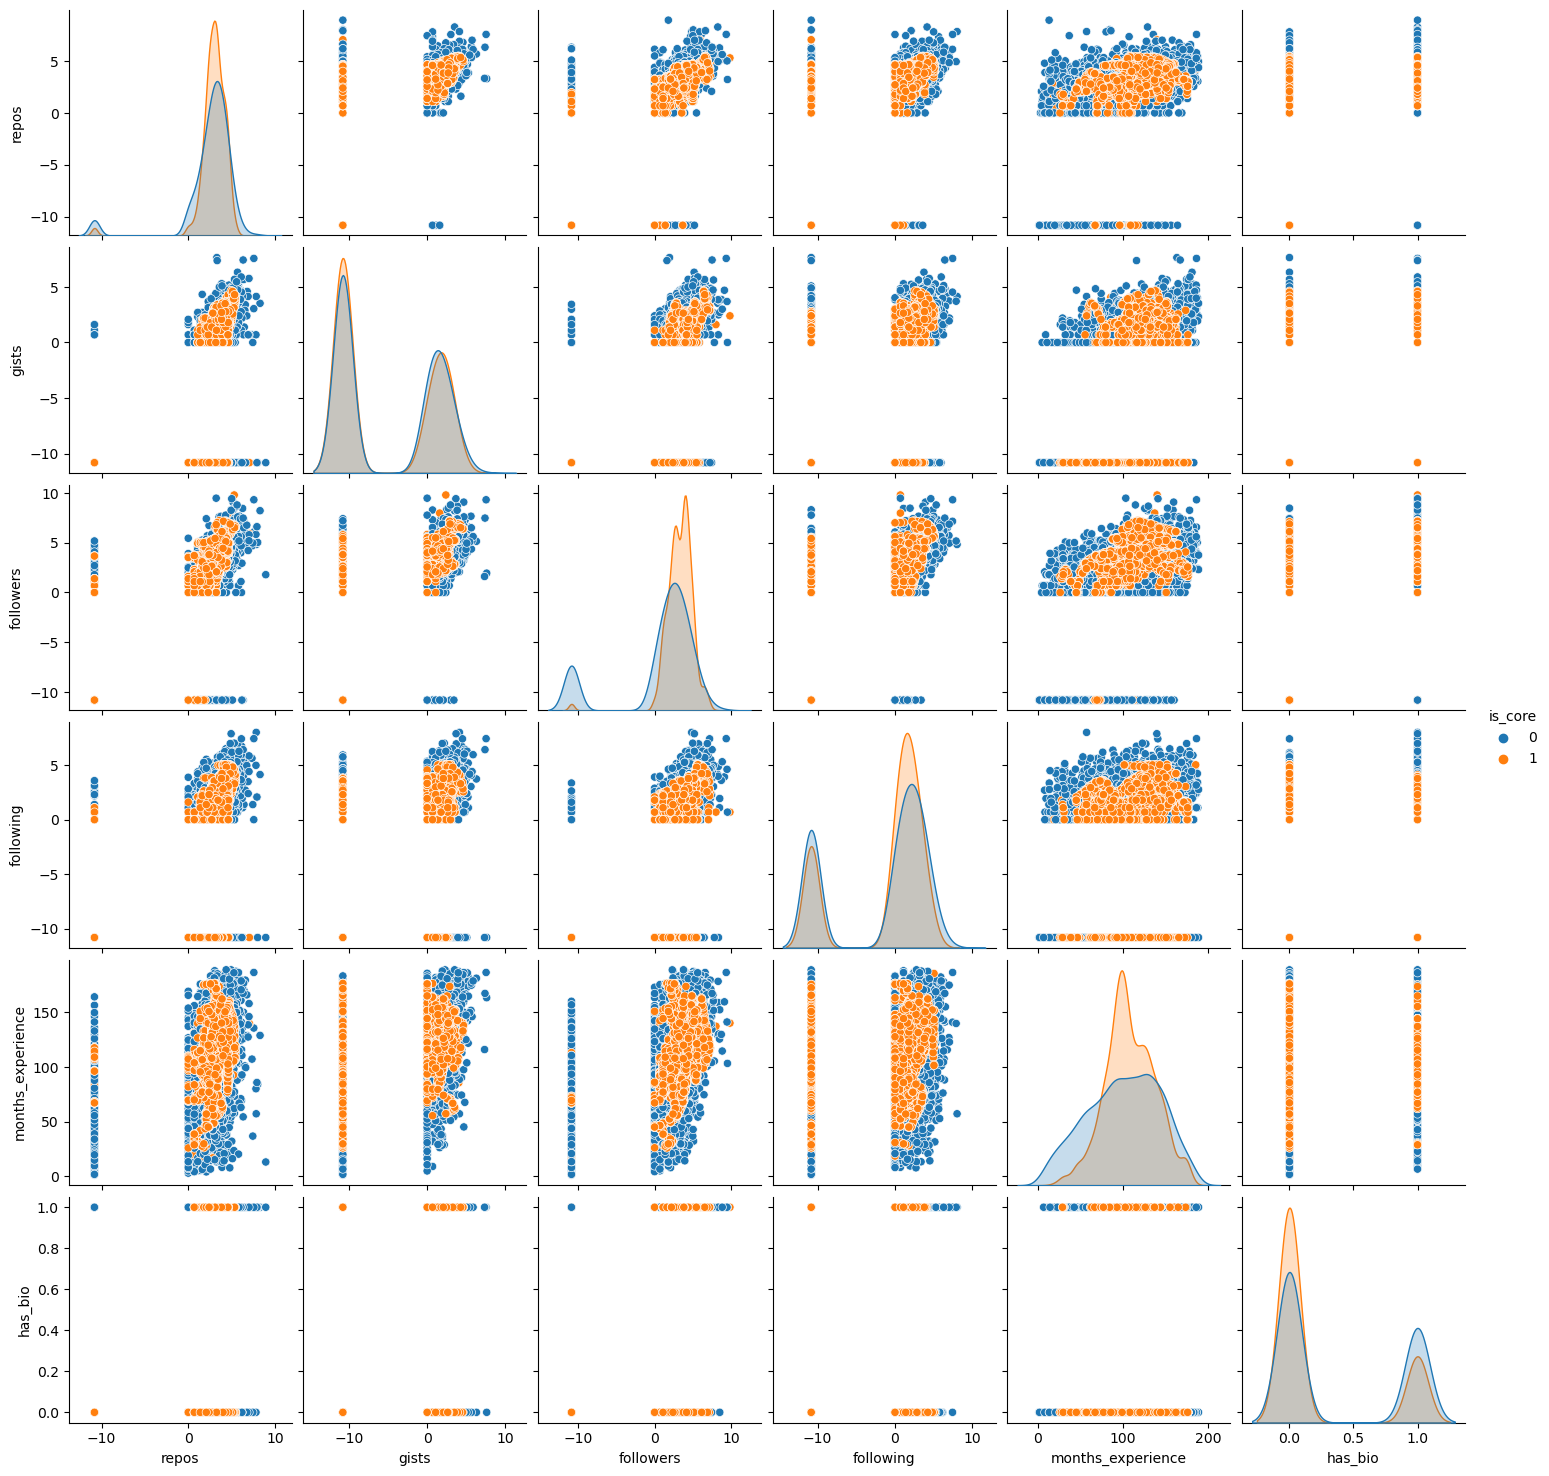

In [21]:
sns.pairplot(c1_train_log, hue = 'is_core')

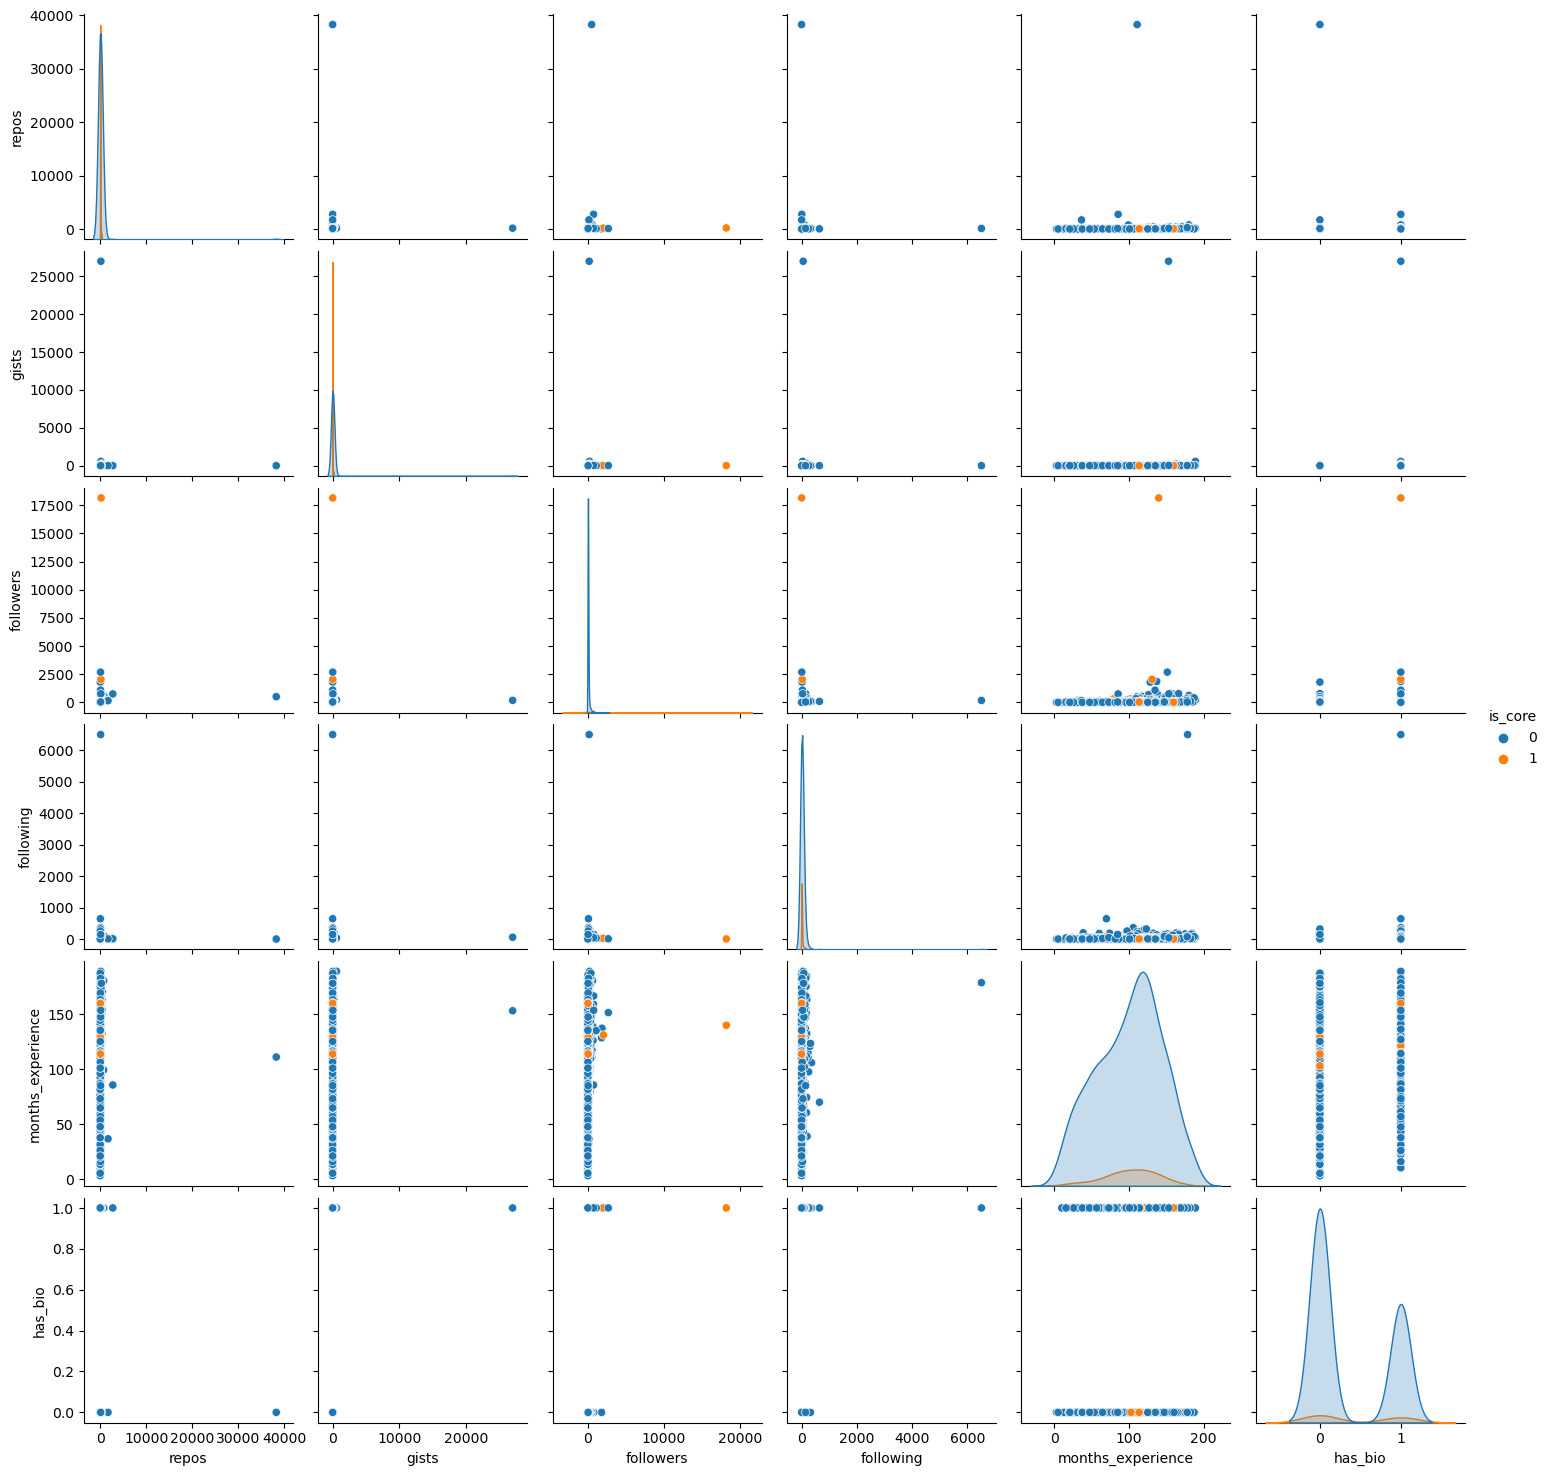

In [22]:
sns.pairplot(test_df, hue = 'is_core')

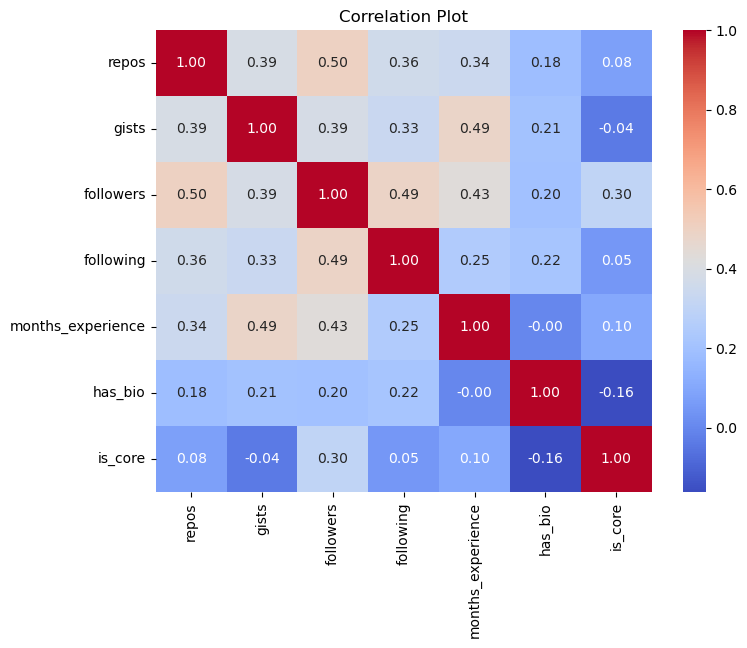

In [23]:
# Creating a correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(c1_train_log.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Adding a title
plt.title('Correlation Plot')

# Displaying the plot
plt.show() 

In [24]:
X = c1_train_log.drop('is_core', axis=1)
y = c1_train_log['is_core']

# Calculating mutual information for each feature
mi_scores = mutual_info_classif(X, y)  # For classification tasks


# Displaying the mutual information scores
for feature, score in zip(X.columns, mi_scores):
    print(f"{feature}: {score:.4f}")

repos: 0.0386
gists: 0.0042
followers: 0.0905
following: 0.0270
months_experience: 0.0773
has_bio: 0.0131


In [25]:
X = c1_train.drop('is_core', axis=1)
y = c1_train['is_core']

# Calculating mutual information for each feature
mi_scores = mutual_info_classif(X, y)  # For classification tasks


# Displaying the mutual information scores
for feature, score in zip(X.columns, mi_scores):
    print(f"{feature}: {score:.4f}")

repos: 0.0471
gists: 0.0155
followers: 0.0876
following: 0.0180
months_experience: 0.0771
has_bio: 0.0099


In [26]:
#scaler = StandardScaler()
#x = scaler.fit_transform(x)
#c1_adasyn_log_scaled = pd.DataFrame(x, columns=['repos', 'gists', 'followers', 'following', 'months_experience'])
#c1_adasyn_log_scaled = pd.concat([c1_adasyn_log_scaled, x2], axis = 1)
#c1_adasyn_log_scaled